In [39]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from tqdm.notebook import tqdm
import os

In [66]:
def greenkhorn(A, r, c, eps, C):
    n = len(C)
    P = A
    one = np.ones(n)
    r_P = P @ one
    c_P = P.T @ one
    
    err = np.linalg.norm(r_P - r, ord=1) + np.linalg.norm(c_P - c, ord=1)
    
    r_gain = r_P - r + r * np.log(r/r_P)
    c_gain = c_P - c + c * np.log(c/c_P)
    k = 0
    while err > eps and k < 15000 :
        i, j = np.argmax(r_gain), np.argmax(c_gain)
        r_gain_max, c_gain_max = r_gain[i], c_gain[j]
        
        if r_gain_max > c_gain_max :
            scaling = r[i] / r_P[i]
            old_row = P[i, : ]
            new_row = scaling * old_row
            P[i, : ] = new_row
            
            P = P / P.sum().sum()
            
            
            r_P = P @ one
            c_P = P.T @ one
            
            r_gain = r_P - r + r * np.log(r/r_P)
            c_gain = c_P - c + c * np.log(c/c_P)
            
            err = np.linalg.norm(r_P - r, ord=1) + np.linalg.norm(c_P - c, ord=1)
            
        else:
            
            scaling = c[j] / c_P[j]
            old_col = P[:, j]
            new_col = scaling * old_col
            P[:, j ] = new_col
            
            P = P / P.sum().sum()
            
            
            r_P = P @ one
            c_P = P.T @ one
            
            r_gain = r_P - r + r * np.log(r/r_P)
            c_gain = c_P - c + c * np.log(c/c_P)
            
            err = np.linalg.norm(r_P - r, ord=1) + np.linalg.norm(c_P - c, ord=1)
        k += 1  
    return P
            
    
    
    

In [6]:
def Sinkhorn(A, r, c, eps, C):
    n = len(C)
    P = A
    #print(P)
    one = np.ones(n)
    r_P = P @ one
    c_P = P.T @ one
    
    err = np.linalg.norm(r_P - r, ord=1) + np.linalg.norm(c_P - c, ord=1)
    
    k = -1
    
    while err > eps :
        k += 1
        
        if k % 2 == 1 :
            r_P = P @ one
            scaling = np.log(r / r_P)
            
            #print("*",scaling)
            P = np.diag(np.exp(scaling)) @ P
                       
         
        else:
            
            c_P = P.T @ one
            scaling = np.log(c / c_P)
            #print("**",scaling)
            #P = (P.T * scaling).T
            P =  P  @ np.diag(np.exp(scaling))      
               
        r_P = P @ one
        c_P = P.T @ one               
        err = np.linalg.norm(r_P - r, ord=1) + np.linalg.norm(c_P - c, ord=1)
            
    return P
            

In [7]:
def round_transpoly(X, r, c):
    n = len(X)
    A = X
    one = np.ones(n)
    r_A = A @ one
    
    for i in range(n):
        scaling = min(1.0, r[i]/r_A[i])
        A[i, :] = scaling * A[i, :]
    
    c_A = A.T @ one

    for j in range(n):
        scaling = min(1, c[i]/c_A[i])
        A[:, j] = scaling * A[:, j]
        
    r_A = A @ one
    c_A = A.T @ one
    
    err_r = r_A - r
    err_c = c_A - c
    
    return A + err_r.reshape(-1, 1) @ err_c.reshape(1, -1) / np.sum(np.abs(err_r))
    
    
    

In [8]:
def kernel(C, eta):
    return np.exp(- eta * C)

In [9]:
def compute_ot(C, r, c, eps, eta, Greenkhorn = True):
    A = kernel(C, eta)
    eps_ = eps / (8*np.max(C))
    if Greenkhorn : 
        P = greenkhorn(A, r, c, eps_, C)
    else:
        P = Sinkhorn(A, r, c, eps_, C)
        #print(P)
    
    P = round_transpoly(P, r, c)
    
    return np.vdot(P, C)

In [21]:
def Exact(C, r, c):
    d = len(C)
    P = cp.Variable((d,d))
    u = np.ones((d, 1))
    v = np.ones((d, 1))
    r = r.reshape((d, 1))
    c = c.reshape((1, d))
    U = [0 <= P, P @ u == r, v.T @ P == c]
    objective = cp.Minimize( cp.sum(cp.multiply(P,C)) )
    prob = cp.Problem(objective, U)
    result = prob.solve()
    return result

In [105]:
def error_pr(C, r, c, epss, Greenkhorn = True):
    exc = Exact(C, r, c)
    n = len(epss)
    eps_pr = np.zeros(n)
    for i in tqdm(range(n)) :
        eta = np.log(np.log(len(C)))**0.5/epss[i]
        app = compute_ot(C, r, c, epss[i], eta, Greenkhorn = Greenkhorn)
        eps_pr[i] = app - exc
    return eps_pr

In [69]:
def random_cov_matrix(d, alpha=1/3):

    k = int(np.round(d/alpha))
    M = np.random.normal(size=(k,d))
    A_tilde = M.T@M
    A = A_tilde / np.trace(A_tilde)
    return A

def random_cov_matrix_k(d, alpha=1/3):

    k = int(np.round(d/alpha))
    M = np.random.normal(size=(k,d))
    A_tilde = M.T@M
    A = A_tilde / k
    return A

def mat_sqrt(A):
    u, s, vh = np.linalg.svd(A)
    return (u * np.sqrt(s)) @ vh

def random_uniform_sphere(d, size=1):
    x = np.random.normal(size=(size,d))
    return x / np.linalg.norm(x,axis=-1, keepdims=True)

def random_R(d, alpha, beta, size=1):
    z = np.random.normal(size=size)
    return alpha*np.abs(np.arctan(z/beta))**(1/d)

def estimate_alpha(beta, d, nb_steps=10000):
    R = random_R(d, 1, beta, size=nb_steps)
    return np.sqrt(d) / np.mean(R*R)

def sample_X(d, alpha, beta, A, size=1):
    A_sqrt = mat_sqrt(A)
    R = random_R(d, alpha, beta, size=1)
    U = random_uniform_sphere(d, size=size)
    return (R * U) @ A_sqrt

def cost_matrix(mu, nu):
    diff = mu[:,np.newaxis,:] - nu[np.newaxis, :,:]
    C = 0.5*np.sum(diff*diff, axis=-1)
    return C

In [15]:
d = 50
r = np.random.randint(1000, size = d)
c = np.random.randint(1000, size = d)
r = r/r.sum()
c = c/c.sum()
mean = np.ones(d) * 10
cov = 3 * np.eye(d)
C = np.random.multivariate_normal(mean, cov, d) 

In [106]:
n = 500
d = 5
A = random_cov_matrix(d)
beta = 1
lbda = 0.000001
alpha = estimate_alpha(beta, d)
mu = sample_X(d, alpha, beta, A, n)
nu = sample_X(d, alpha, beta, A, n)
C = cost_matrix(mu, nu)
p = np.ones(len(mu))/len(mu)
q = np.ones(len(nu))/len(nu)

In [107]:
epss = 10**(-3) * np.array([80,90,100,110,120,130,140,150,160, 180, 200, 220] )#,170,180,190,200,210,220,230])
eps_pr = error_pr(C, p, q, epss, True)
print(epss)
print(eps_pr)

  0%|          | 0/12 [00:00<?, ?it/s]

[0.08 0.09 0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.18 0.2  0.22]
[0.06701999 0.07879291 0.09197742 0.10379478 0.11711177 0.13023578
 0.14029428 0.15501503 0.16518195 0.18772547 0.21047522 0.23671777]


In [108]:
def mk_plot(err1, err2, n,name="error.png"):
    """
    """
    figure = plt.figure(figsize=(12, 8))
    plt.plot(err1, label="theoritic")
    plt.plot(err2, label="experimental")
    beta=3000.0
    
    error = np.ones_like(err1)
    error = err1.std()*error
    plt.fill_between(np.array(list(range(len(err1)))), err1-error/beta, err1+error/beta, alpha=0.45)
    
    error = np.ones_like(err2)
    error = err2.std()*error
    plt.fill_between(np.array(list(range(len(err2)))), err2-error/beta, err2+error/beta, alpha=0.45)
    
    plt.grid()
    plt.legend()
    plt.title("Error comparison, $\lambda = \sqrt{\log{(n)}}/ \epsilon $")
    plt.ylabel("$\epsilon$ values")
    plt.savefig(os.path.join(r"path", name))
    plt.show()
    return

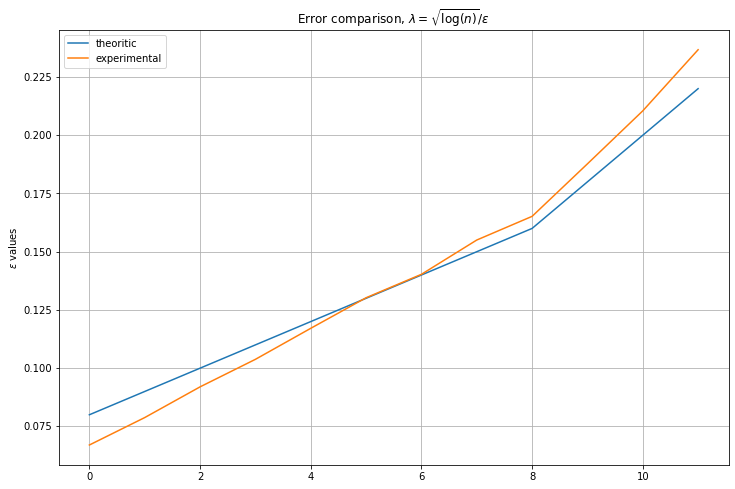

In [109]:
mk_plot(epss, eps_pr, 1000, name="error 8.png")